## Imports

In [4]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
import haversine as hs

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, confusion_matrix, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

## Import data

In [5]:
# Create a function to import the identified data files:

def import_data(dict_of_file_paths):
    def pd_read_csv(file_path):
        return pd.read_csv(file_path)
    
    dataframes = {}

    for key, file_path in dict_of_file_paths.items():
        dataframes[f'{key}_df'] = pd_read_csv(file_path)

    return dataframes

In [6]:
# Define dictionary of file paths to be passed into the import_data function

file_paths = {
    'train': '../assets/train.csv',
    'spray': '../assets/spray.csv',
    'test': '../assets/test.csv',
    'weather': '../assets/weather.csv'
}

In [7]:
# Assign output of import_data to the variable dataframes
dataframes = import_data(file_paths)

In [8]:
# Print keys of dataframes to see how many dataframes we have
dataframes.keys()

dict_keys(['train_df', 'spray_df', 'test_df', 'weather_df'])

### Checking each dataframe's info() and isnull() values

In [9]:
for each_df in dataframes.keys():
    print(f'{each_df}: ---------------------------------------------------' '\n')
    dataframes[each_df].info()
    print()
    print('++++++++++')
    print()
    print(f'Check of null values for {each_df}:')
    print(dataframes[each_df].isnull().sum())
    print()

train_df: ---------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB

++++++++++

Check of 

In [10]:
# Thus far only the Time column in spray_df is showing 584 null values.
# However from weather.csv we know that there are '-' and 'M' which are missing values
dataframes['weather_df'] = pd.read_csv('../assets/weather.csv', na_values=['-', 'M'])

In [11]:
dataframes['weather_df'].isnull().sum()

Station           0
Date              0
Tmax              0
Tmin              0
Tavg             11
Depart         1472
DewPoint          0
WetBulb           4
Heat             11
Cool             11
Sunrise        1472
Sunset         1472
CodeSum           0
Depth          1472
Water1         2944
SnowFall       1472
PrecipTotal       2
StnPressure       4
SeaLevel          9
ResultSpeed       0
ResultDir         0
AvgSpeed          3
dtype: int64

### Based on this initial import and checks:  
* train_df: no null values  
* test_df: no null values  
* spray_df:  
    * Time: 584 null
* weather_df:
    * Tavg, Heat, Cool: 11 null
    * Depart, Sunrise, Sunset, Depth, SnowFall: 1472 null
    * WetBulb, StnPressure: 4 null
    * PrecipTotal: 2 null
    * SeaLevel: 9 null
    * AvgSpeed: 3 null


---
## EDA with train_df

In [12]:
train_df = dataframes['train_df']
train_df

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10501,2013-09-26,"5100 West 72nd Street, Chicago, IL 60638, USA",CULEX PIPIENS/RESTUANS,51,W 72ND ST,T035,"5100 W 72ND ST, Chicago, IL",41.763733,-87.742302,8,6,1
10502,2013-09-26,"5800 North Ridge Avenue, Chicago, IL 60660, USA",CULEX PIPIENS/RESTUANS,58,N RIDGE AVE,T231,"5800 N RIDGE AVE, Chicago, IL",41.987280,-87.666066,8,5,0
10503,2013-09-26,"1700 North Ashland Avenue, Chicago, IL 60622, USA",CULEX PIPIENS/RESTUANS,17,N ASHLAND AVE,T232,"1700 N ASHLAND AVE, Chicago, IL",41.912563,-87.668055,9,1,0
10504,2013-09-26,"7100 North Harlem Avenue, Chicago, IL 60631, USA",CULEX PIPIENS/RESTUANS,71,N HARLEM AVE,T233,"7100 N HARLEM AVE, Chicago, IL",42.009876,-87.807277,9,5,0


In [13]:
# Convert column names to snake_case
def convert_to_snake_case(text):
    words = re.findall(r'[A-Z][a-z0-9]*', text)
    snake_case_name = '_'.join(words).lower()
    return snake_case_name

train_df.columns = [convert_to_snake_case(column) for column in train_df.columns]

In [14]:
# Change date column to datetime object
train_df['date']=pd.to_datetime(train_df['date'])

# Create separate columns for Year, Month and Date for EDA later on
train_df['year']=train_df['date'].dt.year
train_df['month']=train_df['date'].dt.month
train_df['day']=train_df['date'].dt.day

### Combining rows of test results

According to the [Kaggle](https://www.kaggle.com/competitions/predict-west-nile-virus/data) brief, the results from testing traps are organized in such a way that when the number of mosquitos exceed 50, they are split into another row in the dataset.  
To fix this, we need to combine such records into a single record.

In [15]:
# Strip any white spacings before / after string type data to ensure the groupby is done correctly
train_df = train_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [16]:
train_df = train_df.groupby([col for col in train_df.columns if col not in ['num_mosquitos', 'wnv_present']]).sum()
train_df.reset_index(inplace=True)

In [17]:
# Check if the groupby worked
train_df[(train_df['date']=='2007-07-18') & (train_df['address']=='South Stony Island Avenue, Chicago, IL, USA')]

,date,address,species,block,street,trap,address_number_and_street,latitude,longitude,address_accuracy,year,month,day,num_mosquitos,wnv_present
522,2007-07-18,"South Stony Island Avenue, Chicago, IL, USA",CULEX PIPIENS/RESTUANS,10,S STONY ISLAND AVE,T138,"1000 S STONY ISLAND AVE, Chicago, IL",41.726465,-87.585413,5,2007,7,18,100,0
523,2007-07-18,"South Stony Island Avenue, Chicago, IL, USA",CULEX RESTUANS,10,S STONY ISLAND AVE,T138,"1000 S STONY ISLAND AVE, Chicago, IL",41.726465,-87.585413,5,2007,7,18,76,0
524,2007-07-18,"South Stony Island Avenue, Chicago, IL, USA",CULEX SALINARIUS,10,S STONY ISLAND AVE,T138,"1000 S STONY ISLAND AVE, Chicago, IL",41.726465,-87.585413,5,2007,7,18,2,0


In [18]:
# Assigning 2 classes to 'wnv_present' column: 1 for wnv is present; 0 for wnv is not present
train_df['wnv_present']=train_df['wnv_present'].apply(lambda x: 1 if x>=1 else 0)

In [19]:
train_df['wnv_present'].unique()

array([0, 1])

In [20]:
train_df.shape

(8475, 15)

After combining the rows belonging to the same test, there are 8475 entries in train_df.

### Species of mosquitos 

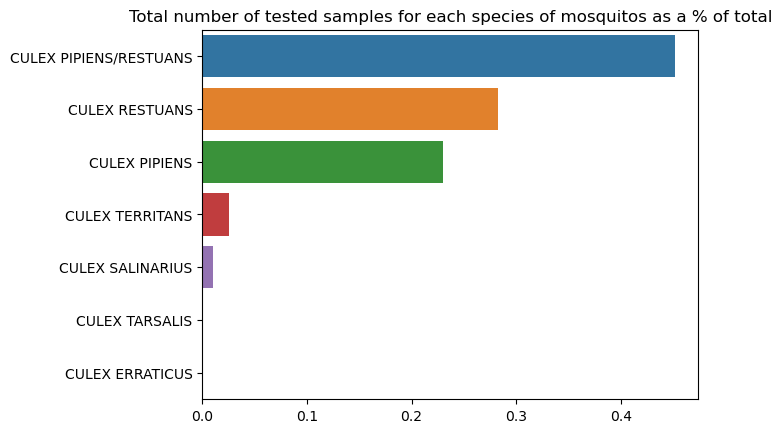

In [21]:
sns.barplot(x=train_df['species'].value_counts(normalize=True).values, y=train_df['species'].value_counts().index)
plt.title('Total number of tested samples for each species of mosquitos as a % of total')
plt.show()

### Species of mosquitos that tested positive for wnv

In [22]:
mozzies_with_wnv = train_df[['species', 'wnv_present', 'num_mosquitos']].groupby('species').sum()

In [23]:
print(mozzies_with_wnv)

                        wnv_present  num_mosquitos
species                                           
CULEX ERRATICUS                   0              7
CULEX PIPIENS                   184          44671
CULEX PIPIENS/RESTUANS          225          66268
CULEX RESTUANS                   48          23431
CULEX SALINARIUS                  0            145
CULEX TARSALIS                    0              7
CULEX TERRITANS                   0            510


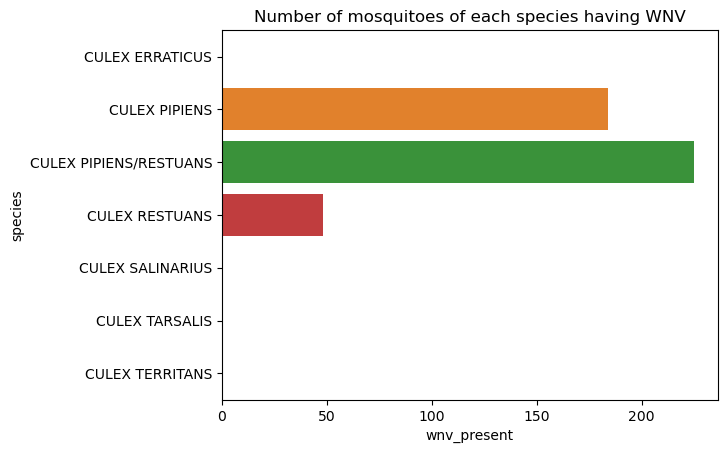

In [24]:
sns.barplot(data=mozzies_with_wnv, x=mozzies_with_wnv['wnv_present'], y=mozzies_with_wnv.index)
plt.title('Number of mosquitoes of each species having WNV')
plt.show()

### Class distribution

In [25]:
train_df['wnv_present'].value_counts(normalize=True)


0    0.946077
1    0.053923
Name: wnv_present, dtype: float64

The data is skewed towards the negative class (wnv not present).

### Testing frequency

In [26]:
for x in ['year', 'month', 'day']:
    print(f'Distribution of testing frequency by {x}:')
    print(train_df[x].value_counts())
    print()

Distribution of testing frequency by year:
2007    2775
2013    2012
2009    1915
2011    1773
Name: year, dtype: int64

Distribution of testing frequency by month:
8     2750
7     2096
9     1947
6     1337
10     264
5       81
Name: month, dtype: int64

Distribution of testing frequency by day:
12    700
19    558
1     549
15    533
24    492
25    486
17    375
7     366
26    347
5     319
29    307
21    282
2     276
4     270
8     270
11    264
6     246
27    244
22    215
18    208
14    201
30    145
13    134
28    131
10    131
31    117
16    115
23     98
3      57
9      39
Name: day, dtype: int64



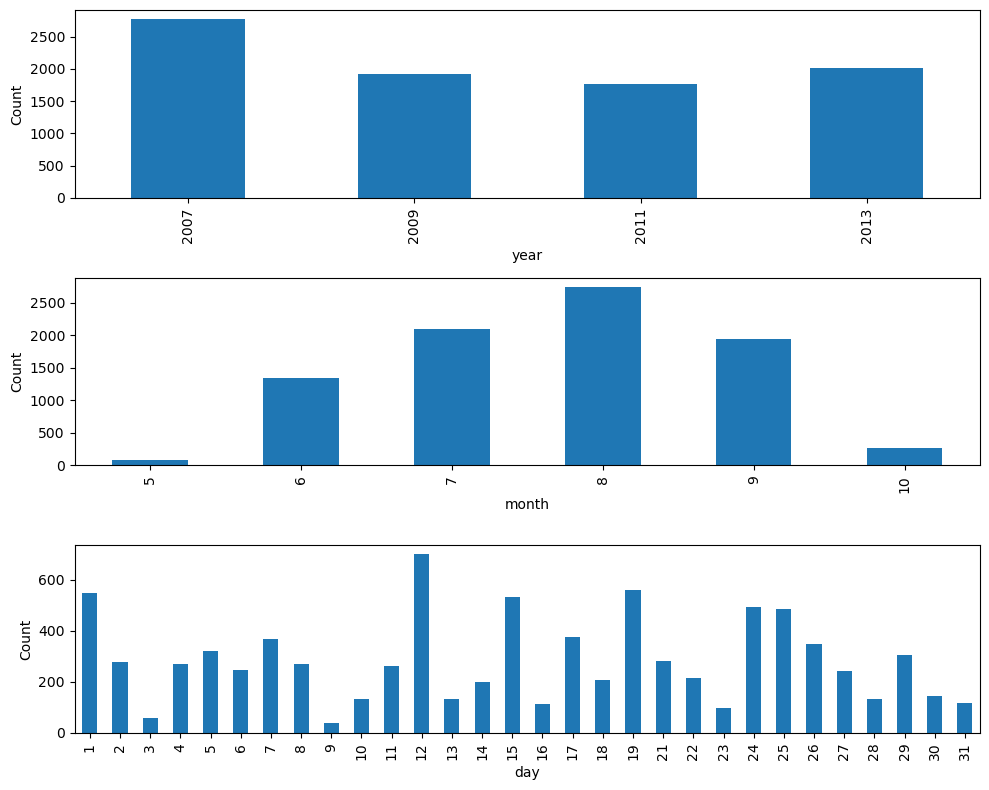

In [27]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))

for i, x in enumerate(['year', 'month', 'day']):
    value_counts = train_df[x].value_counts().sort_index()
    value_counts.plot(kind='bar', ax=axes[i])
    axes[i].set_xlabel(x)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

* Testing frequency by year: only 2007, 2009, 2011, and 2013 are present in this dataset which is expected (mentined in Kaggle brief).  
* Testing frequency by month: Testing is done from May - Oct every year, which is also expected as Kaggle brief mentions that traps are placed from late-May to early-October.  
* Testing frequency by day: the number of tests done per day does not have a pattern.

### WNV present by year and month

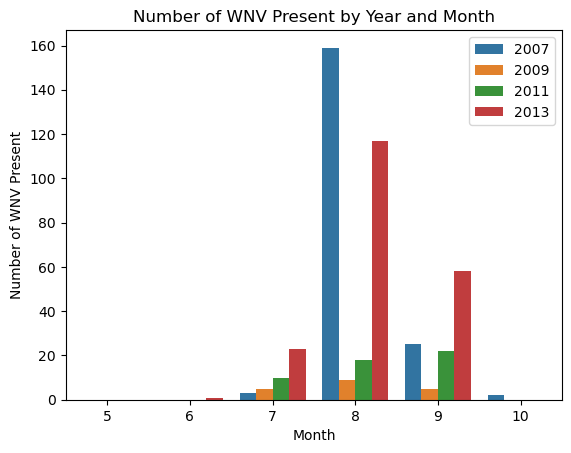

In [28]:
wnv_by_year_month = train_df.groupby(['year', 'month'])['wnv_present'].sum().reset_index()

sns.barplot(data=wnv_by_year_month, x='month', y='wnv_present', hue='year')
plt.xlabel('Month')
plt.ylabel('Number of WNV Present')
plt.title('Number of WNV Present by Year and Month')
plt.legend(loc='upper right')

plt.show()

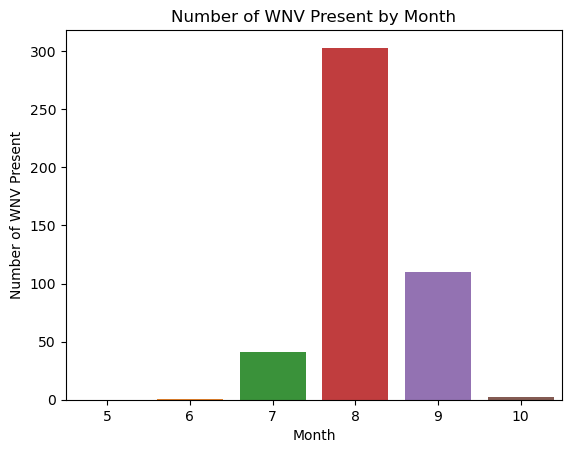

In [29]:
wnv_by_month=train_df.groupby('month')['wnv_present'].sum().reset_index()

sns.barplot(data=wnv_by_month, x='month', y='wnv_present')
plt.xlabel('Month')
plt.ylabel('Number of WNV Present')
plt.title('Number of WNV Present by Month')

plt.show()

Number of wnv present is highest in Aug but we need to be aware that testing was also done more frequently in Aug.

### Trap EDA

In [30]:
len(train_df['trap'].unique())

136

In [31]:
train_df['trap'].value_counts()

T900     154
T135     147
T002     147
T115     143
T151     143
        ... 
T078       6
T076       5
T094B      5
T237       3
T040       2
Name: trap, Length: 136, dtype: int64

In [32]:
train_df[train_df['trap'].str.len()==5]['trap'].value_counts()

T054C    9
T094B    5
Name: trap, dtype: int64

There are 136 unique traps, 2 of which are satellite traps.  
T900 was tested the most.

---
## EDA with weather_df

In [33]:
weather_df = dataframes['weather_df']

In [34]:
# Convert column names to snake_case
weather_df.columns = [convert_to_snake_case(column) for column in weather_df.columns]

In [35]:
# Change date column to datetime object
weather_df['date']=pd.to_datetime(weather_df['date'])

# Create separate columns for Year, Month and Date for EDA later on
weather_df['year']=weather_df['date'].dt.year
weather_df['month']=weather_df['date'].dt.month
weather_df['day']=weather_df['date'].dt.day

In [36]:
weather_df.head()

,station,date,tmax,tmin,tavg,depart,dew_point,wet_bulb,heat,cool,...,snow_fall,precip_total,stn_pressure,sea_level,result_speed,result_dir,avg_speed,year,month,day
0,1,2007-05-01,83,50,67.0,14.0,51,56.0,0.0,2.0,...,0.0,0.00,29.10,29.82,1.7,27,9.2,2007,5,1
1,2,2007-05-01,84,52,68.0,NaN,51,57.0,0.0,3.0,...,NaN,0.00,29.18,29.82,2.7,25,9.6,2007,5,1
2,1,2007-05-02,59,42,51.0,-3.0,42,47.0,14.0,0.0,...,0.0,0.00,29.38,30.09,13.0,4,13.4,2007,5,2
3,2,2007-05-02,60,43,52.0,NaN,42,47.0,13.0,0.0,...,NaN,0.00,29.44,30.08,13.3,2,13.4,2007,5,2
4,1,2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,...,0.0,0.00,29.39,30.12,11.7,7,11.9,2007,5,3


In [37]:
weather_df.isnull().sum()

station            0
date               0
tmax               0
tmin               0
tavg              11
depart          1472
dew_point          0
wet_bulb           4
heat              11
cool              11
sunrise         1472
sunset          1472
code_sum           0
depth           1472
water1          2944
snow_fall       1472
precip_total       2
stn_pressure       4
sea_level          9
result_speed       0
result_dir         0
avg_speed          3
year               0
month              0
day                0
dtype: int64

In [38]:
weather_df_null_counts = weather_df.isnull().sum()
weather_df_total_rows = len(weather_df)
weather_df_null_percentage = (weather_df_null_counts / weather_df_total_rows) * 100
print(weather_df_null_percentage)

station           0.000000
date              0.000000
tmax              0.000000
tmin              0.000000
tavg              0.373641
depart           50.000000
dew_point         0.000000
wet_bulb          0.135870
heat              0.373641
cool              0.373641
sunrise          50.000000
sunset           50.000000
code_sum          0.000000
depth            50.000000
water1          100.000000
snow_fall        50.000000
precip_total      0.067935
stn_pressure      0.135870
sea_level         0.305707
result_speed      0.000000
result_dir        0.000000
avg_speed         0.101902
year              0.000000
month             0.000000
day               0.000000
dtype: float64


Let's have a look at each column with null values and how we can address them:


* tavg - addressing null values

In [39]:
for i in weather_df[pd.isnull(weather_df['tavg'])]:
    weather_df['tavg']=round((weather_df['tmax']+weather_df['tmin'])/2)

In [40]:
weather_df['normal']=np.nan

for index, row in weather_df.iterrows():
    if row['station'] == 1:
        weather_df.at[index, 'normal'] = int(row['tavg']) - int(row['depart'])
    if row['station'] == 2:
        matching_row = weather_df[(weather_df['station'] == 1) & (weather_df['date'] == row['date'])]
        weather_df.at[index, 'normal'] = matching_row['normal']
       

In [41]:
for index, row in weather_df[weather_df['station'] == 2].iterrows():
    weather_df.at[index, 'depart'] = int(row['tavg']) - int(row['normal'])

In [42]:
weather_df

,station,date,tmax,tmin,tavg,depart,dew_point,wet_bulb,heat,cool,...,precip_total,stn_pressure,sea_level,result_speed,result_dir,avg_speed,year,month,day,normal
0,1,2007-05-01,83,50,66.0,14.0,51,56.0,0.0,2.0,...,0.00,29.10,29.82,1.7,27,9.2,2007,5,1,52.0
1,2,2007-05-01,84,52,68.0,16.0,51,57.0,0.0,3.0,...,0.00,29.18,29.82,2.7,25,9.6,2007,5,1,52.0
2,1,2007-05-02,59,42,50.0,-3.0,42,47.0,14.0,0.0,...,0.00,29.38,30.09,13.0,4,13.4,2007,5,2,53.0
3,2,2007-05-02,60,43,52.0,-1.0,42,47.0,13.0,0.0,...,0.00,29.44,30.08,13.3,2,13.4,2007,5,2,53.0
4,1,2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,...,0.00,29.39,30.12,11.7,7,11.9,2007,5,3,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,49,40,44.0,-2.0,34,42.0,20.0,0.0,...,0.00,29.42,30.07,8.5,29,9.0,2014,10,29,46.0
2940,1,2014-10-30,51,32,42.0,-4.0,34,40.0,23.0,0.0,...,0.00,29.34,30.09,5.1,24,5.5,2014,10,30,46.0
2941,2,2014-10-30,53,37,45.0,-1.0,35,42.0,20.0,0.0,...,T,29.41,30.10,5.9,23,6.5,2014,10,30,46.0
2942,1,2014-10-31,47,33,40.0,-6.0,25,33.0,25.0,0.0,...,0.03,29.49,30.20,22.6,34,22.9,2014,10,31,46.0


In [43]:
for index, row in weather_df[pd.isna(weather_df['heat'])].iterrows():
    value = row['tavg'] - row['normal']

    if value > 0:
        weather_df.at[index, 'cool'] = value
        weather_df.at[index, 'heat'] = 0

    elif value < 0:
        weather_df.at[index, 'cool'] = 0
        weather_df.at[index, 'heat'] = value
    
    else:
        weather_df.at[index, 'cool'] = 0
        weather_df.at[index, 'heat'] = 0

In [44]:
weather_df.isnull().sum()

station            0
date               0
tmax               0
tmin               0
tavg               0
depart             0
dew_point          0
wet_bulb           4
heat               0
cool               0
sunrise         1472
sunset          1472
code_sum           0
depth           1472
water1          2944
snow_fall       1472
precip_total       2
stn_pressure       4
sea_level          9
result_speed       0
result_dir         0
avg_speed          3
year               0
month              0
day                0
normal             0
dtype: int64

* wet_bulb - addressing null values

In [45]:
# Sunrise, sunset

for index, row in weather_df.iterrows():

    if row['station'] == 2:
        matching_row = weather_df[(weather_df['station'] == 1) & (weather_df['date'] == row['date'])]
        weather_df.at[index, 'sunrise'] = matching_row['sunrise']
        weather_df.at[index, 'sunset'] = matching_row['sunset']

In [46]:
# Depth, water1, snow_fall. Drop.

weather_df=weather_df.drop(['depth', 'water1', 'snow_fall', 'code_sum'], axis=1)

In [47]:
weather_df.isnull().sum()

station         0
date            0
tmax            0
tmin            0
tavg            0
depart          0
dew_point       0
wet_bulb        4
heat            0
cool            0
sunrise         0
sunset          0
precip_total    2
stn_pressure    4
sea_level       9
result_speed    0
result_dir      0
avg_speed       3
year            0
month           0
day             0
normal          0
dtype: int64

In [48]:
for index, row in weather_df.iterrows():
    if ((row['precip_total']=='T') | (row['precip_total']=='  T')):
        weather_df.at[index, 'precip_total'] = 0
    elif row['precip_total']=='M':
        matching_row = weather_df[(weather_df['station'] == 1) & (weather_df['date'] == row['date'])]
        weather_df.at[index, 'precip_total'] = matching_row['precip_total']
        

In [49]:
pd.isna(weather_df).sum()

station         0
date            0
tmax            0
tmin            0
tavg            0
depart          0
dew_point       0
wet_bulb        4
heat            0
cool            0
sunrise         0
sunset          0
precip_total    2
stn_pressure    4
sea_level       9
result_speed    0
result_dir      0
avg_speed       3
year            0
month           0
day             0
normal          0
dtype: int64

In [50]:
# Impute the rest

imputer = KNNImputer(n_neighbors=5)

imputed_values = imputer.fit_transform(weather_df[['station', 'tmax', 'tmin', 'tavg',
                                               'dew_point', 'wet_bulb', 'precip_total', 'stn_pressure', 'sea_level',
                                               'avg_speed']])
weather_df[['station', 'tmax', 'tmin', 'tavg',
            'dew_point', 'wet_bulb', 'precip_total', 'stn_pressure', 'sea_level',
            'avg_speed']] = imputed_values

In [51]:
weather_df

,station,date,tmax,tmin,tavg,depart,dew_point,wet_bulb,heat,cool,...,precip_total,stn_pressure,sea_level,result_speed,result_dir,avg_speed,year,month,day,normal
0,1.0,2007-05-01,83.0,50.0,66.0,14.0,51.0,56.0,0.0,2.0,...,0.00,29.10,29.82,1.7,27,9.2,2007,5,1,52.0
1,2.0,2007-05-01,84.0,52.0,68.0,16.0,51.0,57.0,0.0,3.0,...,0.00,29.18,29.82,2.7,25,9.6,2007,5,1,52.0
2,1.0,2007-05-02,59.0,42.0,50.0,-3.0,42.0,47.0,14.0,0.0,...,0.00,29.38,30.09,13.0,4,13.4,2007,5,2,53.0
3,2.0,2007-05-02,60.0,43.0,52.0,-1.0,42.0,47.0,13.0,0.0,...,0.00,29.44,30.08,13.3,2,13.4,2007,5,2,53.0
4,1.0,2007-05-03,66.0,46.0,56.0,2.0,40.0,48.0,9.0,0.0,...,0.00,29.39,30.12,11.7,7,11.9,2007,5,3,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2.0,2014-10-29,49.0,40.0,44.0,-2.0,34.0,42.0,20.0,0.0,...,0.00,29.42,30.07,8.5,29,9.0,2014,10,29,46.0
2940,1.0,2014-10-30,51.0,32.0,42.0,-4.0,34.0,40.0,23.0,0.0,...,0.00,29.34,30.09,5.1,24,5.5,2014,10,30,46.0
2941,2.0,2014-10-30,53.0,37.0,45.0,-1.0,35.0,42.0,20.0,0.0,...,0.00,29.41,30.10,5.9,23,6.5,2014,10,30,46.0
2942,1.0,2014-10-31,47.0,33.0,40.0,-6.0,25.0,33.0,25.0,0.0,...,0.03,29.49,30.20,22.6,34,22.9,2014,10,31,46.0


---
## Prep for Merge

In [52]:
    weather_stations = {
        'station1' : { 
            'name': "Chicago O'Hare International Airport",
            'lon': -87.933,
            'lat': 41.995,
            'elev': 662
        },
        'station2' : {
            'name': "Chicago Midway International Airport",
            'lon': -87.752,
            'lat': 41.786,
            'elev': 612
        }
    }

In [53]:
def nearest_station(dataframe):
    for index, row in dataframe.iterrows():
        lat = row['latitude']
        lon = row['longitude']
        datapoint_loc = (lat, lon)
    
        station1_loc = (weather_stations['station1']['lat'], weather_stations['station1']['lon'])
        station2_loc = (weather_stations['station2']['lat'], weather_stations['station2']['lon'])

        dist_station1 = hs.haversine(datapoint_loc, station1_loc)
        dist_station2 = hs.haversine(datapoint_loc, station2_loc)

        if dist_station1 < dist_station2:
            dataframe.loc[index, "station"] = 1
            dataframe.loc[index, "station_dist"] = dist_station1
    
        else:
            dataframe.loc[index, "station"] = 2
            dataframe.loc[index, "station_dist"] = dist_station2
    
    

In [54]:
nearest_station(train_df)

In [55]:
train_df['station'].value_counts()

2.0    6012
1.0    2463
Name: station, dtype: int64

In [56]:
station1_loc = (weather_stations['station1']['lat'], weather_stations['station1']['lon'])
station2_loc = (weather_stations['station2']['lat'], weather_stations['station2']['lon'])
distance_btw_stations = hs.haversine(station1_loc, station2_loc)
print(f'The distance between the 2 weather stations is {distance_btw_stations:.2f} km.')

The distance between the 2 weather stations is 27.65 km.


In [57]:
print(f'train_df shape: {train_df.shape}')
print(f'weather_df shape:{weather_df.shape}')

train_df shape: (8475, 17)
weather_df shape:(2944, 22)


In [58]:
merged_df = pd.merge(train_df, weather_df, on=['date','station'])

In [59]:
merged_df.shape

(8475, 37)

In [60]:
merged_df.columns

Index(['date', 'address', 'species', 'block', 'street', 'trap',
       'address_number_and_street', 'latitude', 'longitude',
       'address_accuracy', 'year_x', 'month_x', 'day_x', 'num_mosquitos',
       'wnv_present', 'station', 'station_dist', 'tmax', 'tmin', 'tavg',
       'depart', 'dew_point', 'wet_bulb', 'heat', 'cool', 'sunrise', 'sunset',
       'precip_total', 'stn_pressure', 'sea_level', 'result_speed',
       'result_dir', 'avg_speed', 'year_y', 'month_y', 'day_y', 'normal'],
      dtype='object')

In [61]:
# Remove duplicated columns
merged_df.drop(columns=['year_y', 'month_y', 'day_y'])

,date,address,species,block,street,trap,address_number_and_street,latitude,longitude,address_accuracy,...,cool,sunrise,sunset,precip_total,stn_pressure,sea_level,result_speed,result_dir,avg_speed,normal
0,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,...,12.0,421.0,1917.0,0.0,29.44,30.09,5.8,16,7.4,64.0
1,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,...,12.0,421.0,1917.0,0.0,29.44,30.09,5.8,16,7.4,64.0
2,2007-05-29,"1100 South Peoria Street, Chicago, IL 60608, USA",CULEX RESTUANS,11,S PEORIA ST,T091,"1100 S PEORIA ST, Chicago, IL",41.862292,-87.648860,8,...,12.0,421.0,1917.0,0.0,29.44,30.09,5.8,16,7.4,64.0
3,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",CULEX RESTUANS,11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,...,12.0,421.0,1917.0,0.0,29.44,30.09,5.8,16,7.4,64.0
4,2007-05-29,"1500 North Long Avenue, Chicago, IL 60651, USA",CULEX RESTUANS,15,N LONG AVE,T153,"1500 N LONG AVE, Chicago, IL",41.907645,-87.760886,8,...,12.0,421.0,1917.0,0.0,29.44,30.09,5.8,16,7.4,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8470,2013-09-26,"7000 West Armitage Avenue, Chicago, IL 60707, USA",CULEX PIPIENS/RESTUANS,70,W ARMITAGE AVENUE,T151,"7000 W ARMITAGE AVENUE, Chicago, IL",41.916265,-87.800515,8,...,0.0,543.0,1742.0,0.0,29.34,30.04,3.8,8,4.2,59.0
8471,2013-09-26,"7100 North Harlem Avenue, Chicago, IL 60631, USA",CULEX PIPIENS/RESTUANS,71,N HARLEM AVE,T233,"7100 N HARLEM AVE, Chicago, IL",42.009876,-87.807277,9,...,0.0,543.0,1742.0,0.0,29.34,30.04,3.8,8,4.2,59.0
8472,2013-09-26,"9100 West Higgins Road, Rosemont, IL 60018, USA",CULEX RESTUANS,91,W HIGGINS RD,T009,"9100 W HIGGINS RD, Chicago, IL",41.992478,-87.862995,8,...,0.0,543.0,1742.0,0.0,29.34,30.04,3.8,8,4.2,59.0
8473,2013-09-26,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,...,0.0,543.0,1742.0,0.0,29.34,30.04,3.8,8,4.2,59.0


In [62]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8475 entries, 0 to 8474
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       8475 non-null   datetime64[ns]
 1   address                    8475 non-null   object        
 2   species                    8475 non-null   object        
 3   block                      8475 non-null   int64         
 4   street                     8475 non-null   object        
 5   trap                       8475 non-null   object        
 6   address_number_and_street  8475 non-null   object        
 7   latitude                   8475 non-null   float64       
 8   longitude                  8475 non-null   float64       
 9   address_accuracy           8475 non-null   int64         
 10  year_x                     8475 non-null   int64         
 11  month_x                    8475 non-null   int64         
 12  day_x 

In [63]:
object_columns = merged_df.select_dtypes(include='object').columns
object_columns

Index(['address', 'species', 'street', 'trap', 'address_number_and_street'], dtype='object')

<font color="red">EDIT HERE TO ONE HOT ENCODE OBJECTS INSTEAD OF DROPPING</font>

In [64]:
numerical_df=merged_df.drop(columns=object_columns)

/var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_3059/4008849786.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = round(numerical_df.corr(), 2)
/var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_3059/4008849786.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


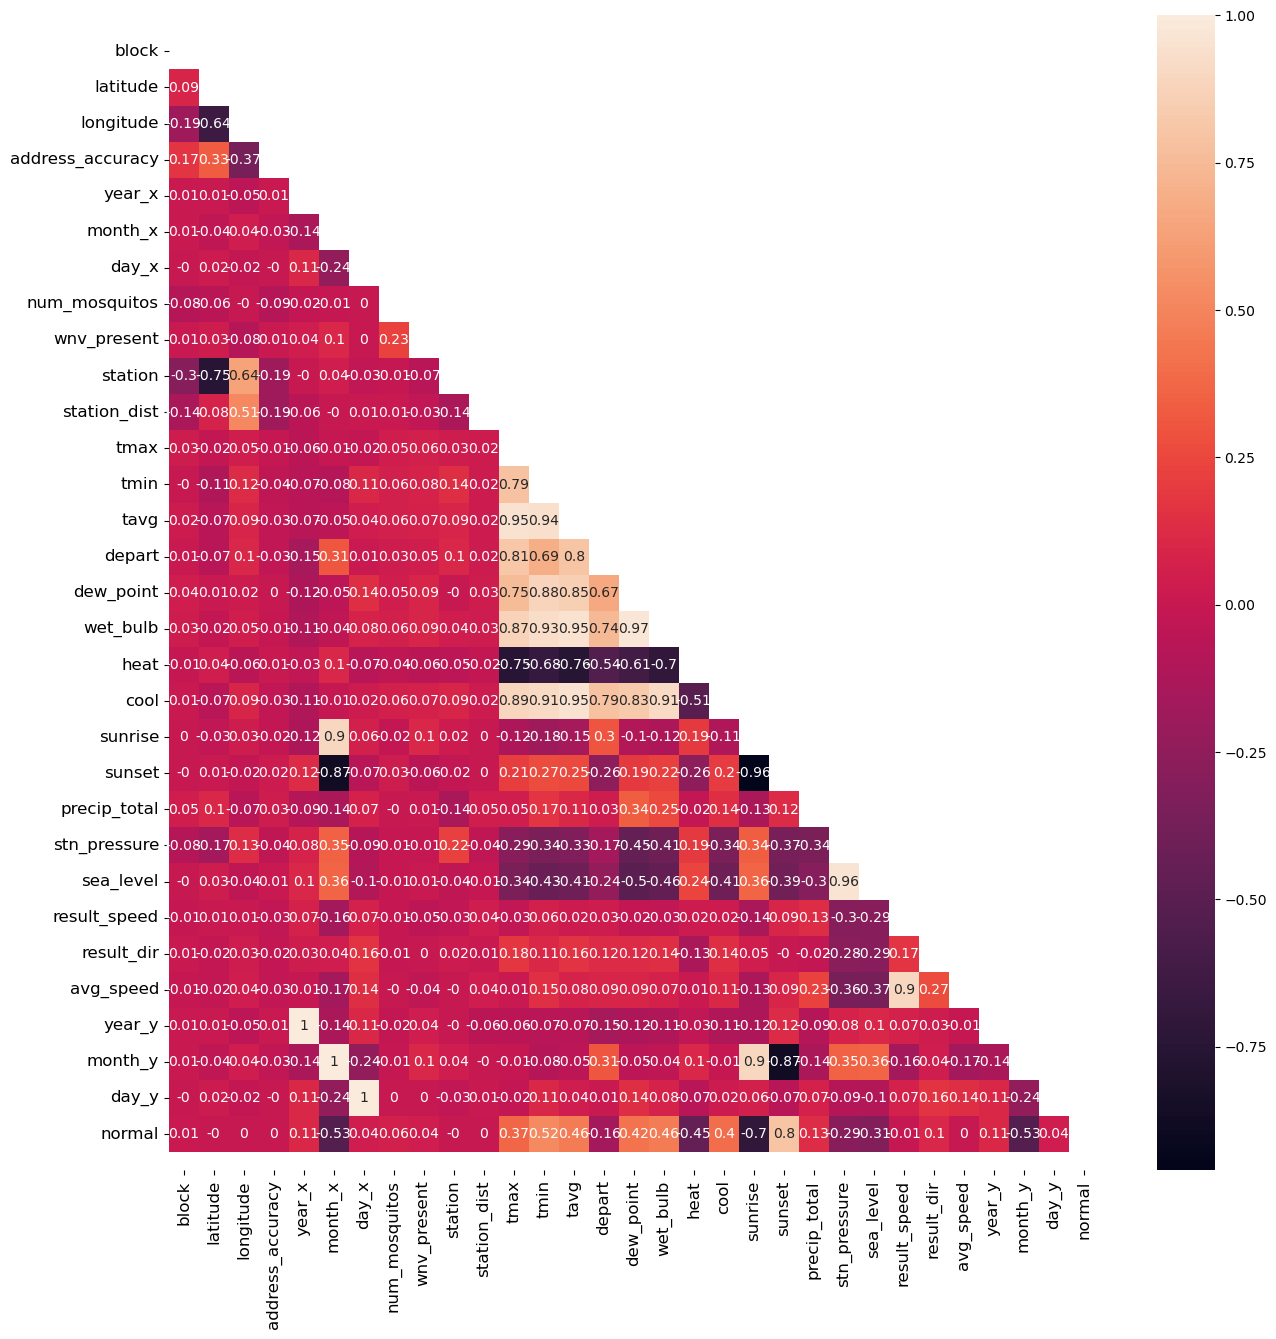

In [65]:
corr = round(numerical_df.corr(), 2)
fix, ax = plt.subplots(figsize=(15,15))

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
ax = sns.heatmap(corr,mask=mask, ax=ax, annot=True)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12, va="center")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top -0.5)

plt.show()

In [66]:
# For weather_df we do expect collinear variables since some are derived mathematically.
# Loop to remove any collinear variable
correlated_features = set()

# Collinearity threshold here is set at 0.9
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.9:
            colname = corr.columns[i]
            correlated_features.add(colname)

print("Collinear Columns to drop: ", correlated_features)


Collinear Columns to drop:  {'year_y', 'month_y', 'cool', 'day_y', 'sunset', 'sea_level', 'wet_bulb', 'tavg'}


In [67]:
model_df = numerical_df.drop(columns=correlated_features)

In [68]:
model_df.columns

Index(['date', 'block', 'latitude', 'longitude', 'address_accuracy', 'year_x',
       'month_x', 'day_x', 'num_mosquitos', 'wnv_present', 'station',
       'station_dist', 'tmax', 'tmin', 'depart', 'dew_point', 'heat',
       'sunrise', 'precip_total', 'stn_pressure', 'result_speed', 'result_dir',
       'avg_speed', 'normal'],
      dtype='object')

In [69]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8475 entries, 0 to 8474
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              8475 non-null   datetime64[ns]
 1   block             8475 non-null   int64         
 2   latitude          8475 non-null   float64       
 3   longitude         8475 non-null   float64       
 4   address_accuracy  8475 non-null   int64         
 5   year_x            8475 non-null   int64         
 6   month_x           8475 non-null   int64         
 7   day_x             8475 non-null   int64         
 8   num_mosquitos     8475 non-null   int64         
 9   wnv_present       8475 non-null   int64         
 10  station           8475 non-null   float64       
 11  station_dist      8475 non-null   float64       
 12  tmax              8475 non-null   float64       
 13  tmin              8475 non-null   float64       
 14  depart            8475 n

---
## Modelling

In [70]:
X = model_df.drop(columns=['wnv_present', 'date'])
y = model_df['wnv_present']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### SMOTE
We have seen that distribution for 'wnv_present' is about 94.6% for the negative class and 5.4% for the positive class. To overcome this, we shall use SMOTE to artificially upsample the minority class so that it is not underrepresented during model training.

In [72]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [73]:
y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: wnv_present, dtype: float64

In [74]:
# Initiate empty models dictionary
models_dict = {}

# Initiate empty metrics dictionary
metrics_dict = {}

# Initiate DataFrame to hold the predictions for validation set
val_preds_df = X_test.copy()

In [78]:

# Def a function to fit model and calculate metrics

def model_fit_metrics(model_name_str, pipe, pipe_params, X_train, 
        X_test, y_train, y_test, models_dict, val_preds_df):
        gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5, scoring = 'roc_auc')
        gs.fit(X_train, y_train)
        best_model = gs.best_estimator_
        models_dict[model_name_str] = gs
        y_preds = best_model.predict(X_test)
        val_preds_df[model_name_str] = y_preds
        print(f'{model_name_str} best params: {gs.best_params_}')

        metrics_dict['train_score'] = f'{best_model.score(X_train, y_train):.3f}'
        metrics_dict['test_score'] = f'{best_model.score(X_test, y_test):.3f}'
        metrics_dict['train_recall'] = f'{recall_score(y_train, best_model.predict(X_train)):.3f}'
        metrics_dict['test_recall'] = f'{recall_score(y_test, y_preds):.3f}'

        # metrics for Confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
        metrics_dict['precision'] = f'{(tp /(tp + fp)):.4f}'
        metrics_dict['specificity'] = f'{(tn / (tn + fp)):.4f}'
        metrics_dict['sensitivity'] = f'{(tp / (tp + fn)):.4f}'
        metrics_dict['true_negatives'] = tn
        metrics_dict['false_positives'] = fp
        metrics_dict['false_negatives'] = fn
        metrics_dict['true_positives'] = tp
        metrics_dict['train_roc_score'] = f'{roc_auc_score(y_train, best_model.predict_proba(X_train)[:,1]):.4f}'
        metrics_dict['test_roc_score'] = f'{roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1]):.4f}'
        metrics_dict['train_cv_score'] = f'{cross_val_score(best_model, X_train, y_train, cv=5).mean():.4f}'
        metrics_dict['test_cv_score'] = f'{cross_val_score(best_model, X_test, y_test, cv=5).mean():.4f}'

        # Create subplots
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

        predicted_probability = [i[1] for i in best_model.predict_proba(X_test)]
        pred_df = pd.DataFrame({'true_values': y_test, 'pred_prob': predicted_probability})

        # Plot ROC curve
        roc_display = RocCurveDisplay.from_predictions(pred_df['true_values'], pred_df['pred_prob'])
        roc_display.plot(ax=axs[0])
        axs[0].plot([0, 1], [0, 1], label='baseline', linestyle='--')
        axs[0].legend()
        axs[0].set_title(f'ROC for {model_name_str}')

        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_preds)
        sns.heatmap(data=cm, cmap=sns.color_palette(['tomato', 'lightgreen'], as_cmap=False), 
                    annot=[[f"TN={cm[0][0]:.0f}", f"FP={cm[0][1]:.0f}"], [f"FN={cm[1][0]:.0f}", f"TP={cm[1][1]:.0f}"]], fmt='', 
                    annot_kws={'fontsize': 12}, cbar=False, square=True, ax=axs[1])
        axs[1].set_title(f'Confusion Matrix for {model_name_str}')
        axs[1].set_xlabel('Predicted')
        axs[1].set_ylabel('Actual')
        axs[1].set_xticklabels(['Negative (0)', 'Positive (1)'])
        axs[1].set_yticklabels(['Negative (0)', 'Positive (1)'])


        plt.tight_layout()
        plt.show()
        
        return models_dict
    
    

---
### Logistic Regression

In [79]:
lr_pipe = Pipeline([
        ('ss', StandardScaler()),
        ('lr', LogisticRegression(random_state=42, max_iter=5000))
    ])
# Paramters
lr_params = {
    'lr__C': np.linspace(0.1, 1, 20)}

log_reg best params: {'lr__C': 1.0}


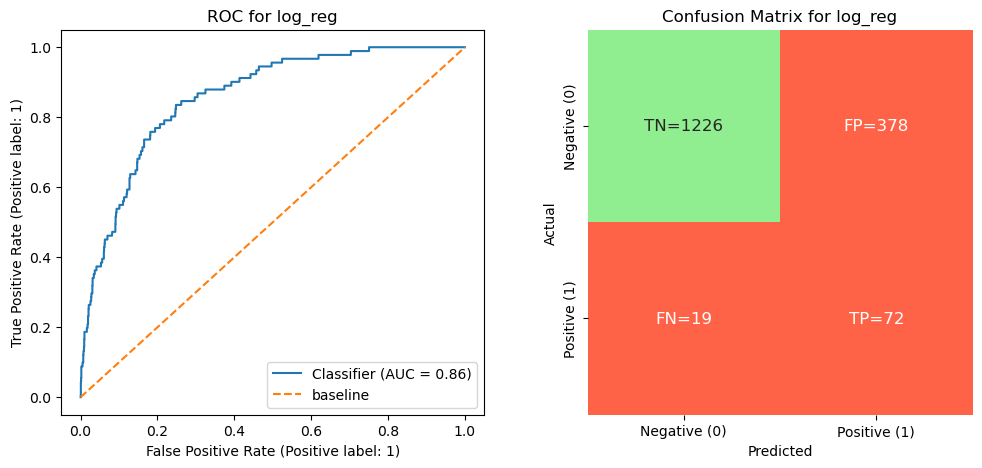

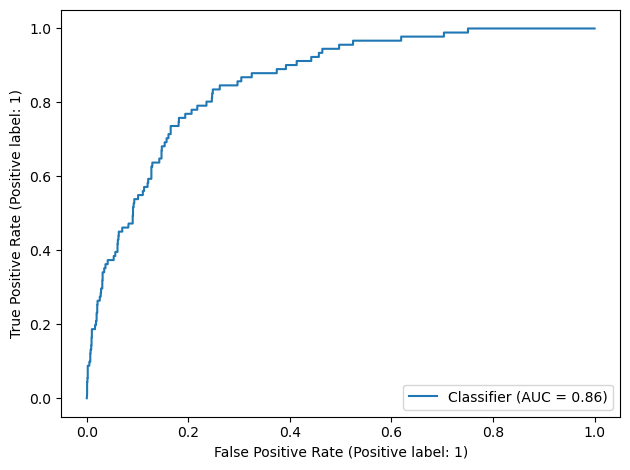

,train_score,test_score,train_recall,test_recall,precision,specificity,sensitivity,true_negatives,false_positives,false_negatives,true_positives,train_roc_score,test_roc_score,train_cv_score,test_cv_score,log_reg
log_reg,0.790,0.766,0.827,0.791,0.1600,0.7643,0.7912,1226,378,19,72,0.8730,0.8583,0.7889,0.9493,"GridSearchCV(cv=5,\n estimator=Pip..."


In [80]:
metrics_dict['log_reg'] = model_fit_metrics('log_reg', lr_pipe, lr_params, X_train, X_test, 
                                   y_train, y_test, models_dict, val_preds_df)
pd.DataFrame(metrics_dict)

---
### Random Forest Classifier

In [83]:
rf_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42)
    )
])

rf_params = {
    'rf__max_depth': [None, 3],
    'rf__n_estimators': [150, 200]
}

random_forest best params: {'rf__max_depth': None, 'rf__n_estimators': 200}


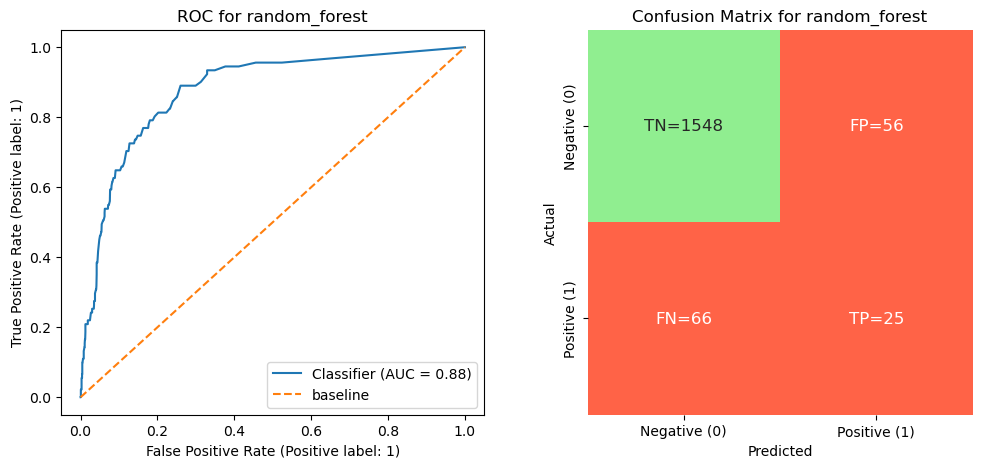

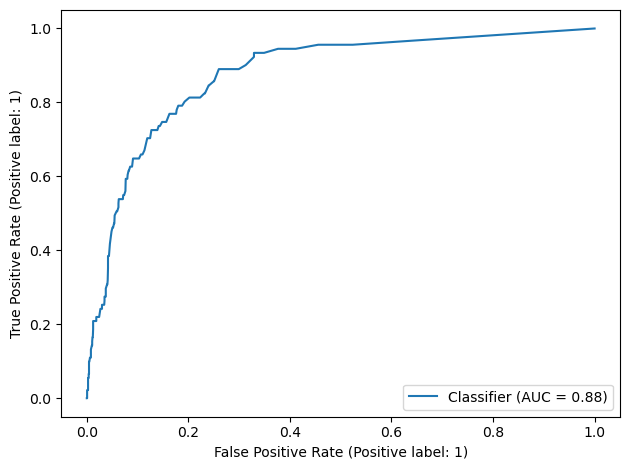

,train_score,test_score,train_recall,test_recall,precision,specificity,sensitivity,true_negatives,false_positives,false_negatives,true_positives,train_roc_score,test_roc_score,train_cv_score,test_cv_score,log_reg
log_reg,0.999,0.928,1.000,0.275,0.3086,0.9651,0.2747,1548,56,66,25,1.0000,0.8767,0.9661,0.9469,"GridSearchCV(cv=5,\n estimator=Pip..."
random_forest,0.999,0.928,1.000,0.275,0.3086,0.9651,0.2747,1548,56,66,25,1.0000,0.8767,0.9661,0.9469,"GridSearchCV(cv=5,\n estimator=Pip..."


In [84]:
metrics_dict['log_reg'] = model_fit_metrics('random_forest', rf_pipe, rf_params, X_train, X_test, 
                                   y_train, y_test, models_dict, val_preds_df)
pd.DataFrame(metrics_dict)